In [1]:
import pandas as pd
pd.options.display.max_columns = None

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
tf.keras.backend.clear_session()
from tensorflow import keras
from tensorflow.keras import layers

### Retrieve the data 

In [3]:
#Load all Files (they must be in data directory in a brother directory of the notebook)
data_load = {
    'dipole_moments': pd.read_csv('./data/magnetic_shielding_tensors.csv'),
    'magnetic_shielding_tensors': pd.read_csv('./data/dipole_moments.csv'),
    'mulliken_charges': pd.read_csv('./data/mulliken_charges.csv'),
    'potential_energy': pd.read_csv('./data/potential_energy.csv'),
    'sample_submission': pd.read_csv('./data/sample_submission.csv'),
    'scalar_coupling_contributions': pd.read_csv('./data/scalar_coupling_contributions.csv'),
    'structures': pd.read_csv('./data/structures.csv'),
    'train': pd.read_csv('./data/train.csv'), 
    'test': pd.read_csv('./data/test.csv')
    }

In [4]:
train_all = data_load['train']
MAX_MOL_ATOMS_NB = max(train_all.atom_index_0.max(),train_all.atom_index_1.max()) + 1

# No shuffle to the samples, this will be done later

train_all =  pd.get_dummies(train_all, prefix = 'coupling_type', columns = ['type'])
train_col = train_all.columns

COUPLING_TYPE_NB = 8

train_all.head()
# we have a molecule of methane
# strangely, scalar coupling between identical atoms (we should have a symetric molecule) are slightly different (7 per 100,000)

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,coupling_type_1JHC,coupling_type_1JHN,coupling_type_2JHC,coupling_type_2JHH,coupling_type_2JHN,coupling_type_3JHC,coupling_type_3JHH,coupling_type_3JHN
0,0,dsgdb9nsd_000001,1,0,84.8076,1,0,0,0,0,0,0,0
1,1,dsgdb9nsd_000001,1,2,-11.2570,0,0,0,1,0,0,0,0
2,2,dsgdb9nsd_000001,1,3,-11.2548,0,0,0,1,0,0,0,0
3,3,dsgdb9nsd_000001,1,4,-11.2543,0,0,0,1,0,0,0,0
4,4,dsgdb9nsd_000001,2,0,84.8074,1,0,0,0,0,0,0,0


In [5]:
#Confirmation with the molecule structure
structures = data_load['structures']

structures_col = structures.columns


# Create one_hot_encoding for the atom type
structures = pd.get_dummies(structures, prefix = 'atom', columns = ['atom'])
structures.head()

,molecule_name,atom_index,x,y,z,atom_C,atom_F,atom_H,atom_N,atom_O
0,dsgdb9nsd_000001,0,-0.012698,1.085804,0.008001,1,0,0,0,0
1,dsgdb9nsd_000001,1,0.002150,-0.006031,0.001976,0,0,1,0,0
2,dsgdb9nsd_000001,2,1.011731,1.463751,0.000277,0,0,1,0,0
3,dsgdb9nsd_000001,3,-0.540815,1.447527,-0.876644,0,0,1,0,0
4,dsgdb9nsd_000001,4,-0.523814,1.437933,0.906397,0,0,1,0,0


Remark: besides train features, data are not provided in the test dataset.

Should we use those as generative features for the scalar coupling constant?"

## Data preparation

### Objectives
* We try to test the following idea: we will train the model with as an input:
 - the couple of atoms nature and positions
 - the position of all other atoms in the molecule, by decreasing distance from the barycentre of the 2 considered atoms
and as ouputs, the J value but also the other properties that are provided
* Create for each sample, ie each couple of atoms for which a coupling constant is provided, the 1D features for standard RNN and the series of molecules atoms positions for the RNN part of the model
* Prepare the additional output, to improve training

For performance improvement, the idea is to create the atoms position in the molecule during the mini-batch creation, not in one go

### Function to create a 2D matrix representing all atoms position for a particular molecule
The function should order the atoms in decreasing distance from the A-B atoms considered

#### Question 1: should we keep the atoms of the coupling in the list of atoms of the molecule ?
I think we do, because we want this list of atoms to predict the global variables of molecule, independently of the coupling prediction

#### Question 2: for J1 coupling, in which order should we return the coupled molecules (as we order based on the center, the order will be arbitrary - based on rounding error)


#### Split train and evaluation sets, at molecule level (it is how the test set is built)

#### Function to prepare the global set

In [6]:
from timeit import default_timer as timer

def create_coupling_per_mol(molecules, coupled_atoms):

    #Transform the input into a dataframe
    molecules = pd.DataFrame(molecules, columns = ['molecule_name', 'atom_index', 'x', 'y', 'z', 'atom_C', 'atom_F', 'atom_H', 'atom_N', 'atom_O'])
    coupled_atoms = pd.DataFrame(coupled_atoms, columns = ['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 
                'scalar_coupling_constant', 'coupling_type_1JHC', 'coupling_type_1JHN', 'coupling_type_2JHC', 
                'coupling_type_2JHH', 'coupling_type_2JHN', 'coupling_type_3JHC', 'coupling_type_3JHH', 'coupling_type_3JHN'])
    
    #0 Select all molecules in the batch first (to quicken the operations)
    molecules_name = coupled_atoms[['molecule_name']].values.reshape(-1)   
    molecules = molecules.loc[molecules['molecule_name'].isin(molecules_name)]

    #2 Prepare the features
    coupled_atoms.drop(['id'], axis = 1, inplace = True)

    coupling_id_col = ['molecule_name', 'atom_index_0', 'atom_index_1' ] 
    mean_col = ['x_mean', 'y_mean', 'z_mean']

    df_tmp = coupled_atoms.merge(molecules, how='inner', 
                               left_on=['molecule_name', 'atom_index_0'], 
                               right_on=['molecule_name', 'atom_index'])
    df_features_dnn = df_tmp.merge(molecules, how='inner', 
                                          left_on=['molecule_name', 'atom_index_1'], 
                                          right_on=['molecule_name', 'atom_index'],
                                         suffixes=('_a0', '_a1')).drop(['atom_index_a0','atom_index_a1' ], axis = 1)
 
    df_features_dnn['x_mean'] = df_features_dnn[['x_a0','x_a1']].mean(axis = 1)
    df_features_dnn['y_mean'] = df_features_dnn[['y_a0','y_a1']].mean(axis = 1)
    df_features_dnn['z_mean'] = df_features_dnn[['z_a0','z_a1']].mean(axis = 1)
    
    # Return a tuple features, labels for each molecule, sorted by molecule order
    gb = df_features_dnn.groupby(['molecule_name'], sort = True, group_keys = False, as_index = True)
            
    features_per_mol = gb.apply(lambda frame: frame.drop(['scalar_coupling_constant']+coupling_id_col, 
                                                         axis = 1).to_numpy()).to_list()
    labels_per_mol = gb.apply(lambda frame: frame['scalar_coupling_constant'].to_numpy()).to_list()
    
    # Return the molecule info per molecule, sorted by molecule order
    gb = molecules.groupby(['molecule_name'], sort = True, group_keys = False, as_index = True)
    molecules_output = gb.apply(lambda frame: frame.drop(['molecule_name', 'atom_index'], axis = 1).to_numpy()).to_list()
    
    return features_per_mol, labels_per_mol, molecules_output

### Prepare the global train/eval sets (about 3 minutes)

In [7]:
from timeit import default_timer as timer
from sklearn.utils import shuffle 

validation_ratio = 0.2

# Retrieve the full list of molecules in the train/eval set
molecule_list = train_all['molecule_name'].unique()

# Split the train/eval sets on the molecule list
train_mol, eval_mol = np.split(molecule_list, [int((1-validation_ratio)*len(molecule_list))])
start = timer()

# Select the samples belonging to the molecule train set (WARNING: there is no shuffle there!!)
train_molecules = structures[structures['molecule_name'].isin(train_mol)]
train_set, train_labels, train_mols = create_coupling_per_mol(train_molecules,
                                    train_all.loc[train_all['molecule_name'].isin(train_mol)]
                                    )
# Shuffle the samples by molecule
shuffle(train_set, train_labels, train_mols)

train_stop = timer()

# Select the samples belonging to the molecule eval set (WARNING: there is no shuffle there!!)
eval_molecules = structures[structures['molecule_name'].isin(eval_mol)]
eval_set, eval_labels, eval_mols = create_coupling_per_mol(eval_molecules,
                                    train_all.loc[train_all['molecule_name'].isin(eval_mol)]
                                    )

# Shuffle the samples by molecule
shuffle(eval_set, eval_labels, eval_mols )

stop = timer()

print('Number of samples: \nfor train set:', len(train_set), '\nfor eval set:', len(eval_set))
print('Time for train / eval:', train_stop-start, '/', stop-train_stop)

Number of samples: 
for train set: 68002 
for eval set: 17001
Time for train / eval: 98.084993449 / 24.619917079999993


In [8]:
train_mols[1000].shape

(21, 8)

#### To save the global set of molecules

In [9]:
# Step 1
import pickle

global_data = {
    'train_set': train_set,
    'train_labels': train_labels,
    'train_mol': train_mols,
    'eval_set': eval_set,
    'eval_labels': eval_labels,
    'eval_mol': eval_mols
    }

# Step 2
with open('train-eval-dump', 'wb') as dump_file:
 
  # Step 3
  pickle.dump(global_data, dump_file)

#### To load the global set of molecules

In [10]:
import pickle

with open('train-eval-dump', 'rb') as dump_file:
    global_data = pickle.load(dump_file)

### Generation of the dataset

#### Function to process (associate and sort) the molecule atoms 

In [11]:
MASKING_VALUE = 666

@tf.function
def treat_molecule_set(features, molecules, labels):

    coupled_atoms_set = tf.convert_to_tensor(features)
    molecule = tf.convert_to_tensor(molecules)
    labels = tf.convert_to_tensor(labels)
    
    mol_atoms_nb = tf.shape(molecule)[0]
    init_molecule = molecule
    
    # Extend the molecule to 3D and transpose it 
    molecule = tf.reshape(molecule[:,:3], [-1, 3, 1])
    molecule = tf.transpose(molecule, [2, 1, 0])
    
    # We repeat the molecules and the mean values, so they have the same n_samples * n_atoms dimension
    molecule = tf.tile(molecule, [tf.shape(coupled_atoms_set)[0], 1, 1])

    mean_3d = tf.reshape(coupled_atoms_set[:, -3:], [-1, 3, 1])  
    mean_3d = tf.tile(mean_3d, [1, 1, mol_atoms_nb])
    
    # We calculate the distance 
    distance = tf.reduce_sum(tf.square(tf.subtract(molecule, mean_3d)), 1)
    
    # This function defines for each sample the atoms of the molecule, sorted by decreasing order
    ordered_idx = tf.argsort(
        distance,
        axis=1,
        direction='DESCENDING',
        stable=False,
        name=None
    )
    
    # We apply this sorting order to the initial molecule to calculate, for each couple of atoms, 
    # the atoms sorted by decreasing distance
    sort_mol = tf.gather(
        init_molecule,
        ordered_idx
    )
    
    # Pad with 666 to keep the same size (is that even needed?)
    sort_mol = tf.pad(sort_mol, [[0,0],[0,MAX_MOL_ATOMS_NB-mol_atoms_nb],[0,0]], constant_values=MASKING_VALUE)
    
    return { 'input_dnn': coupled_atoms_set, 
          'input_rnn': sort_mol
        }, { 'labels': labels }

#### Creation of the full data set

In [12]:
from timeit import default_timer as timer

features = global_data['train_set']
molecules = global_data['train_mol']
labels = global_data['train_labels']

def gen_mol():
    for i in range(len(features)):     
        yield features[i], molecules[i], labels[i]

dataset = tf.data.Dataset.from_generator(
    gen_mol , (tf.float32, tf.float32, tf.float32), 
    (tf.TensorShape([None, 27]), tf.TensorShape([None,8]), tf.TensorShape([None,]) ))

dataset = dataset.flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices(treat_molecule_set(x, y, z)))

dataset = dataset.batch(250)
dataset = dataset.prefetch(1)
start = timer()

i=0
for (feat, mol), label in dataset.take(1000):
    i = i+1 

stop = timer()
    
print("Time to get 1000 batch * 250 samples:",stop-start)

W0701 21:10:26.603379 10776 deprecation.py:323] From D:\Program_Files\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:410: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Time to get 1000 batch * 250 samples: 2.5005842630000075


In [13]:
eval_features = global_data['eval_set']
eval_molecules = global_data['eval_mol']
eval_labels = global_data['eval_labels']

def eval_gen_mol():
    for i in range(len(eval_features)):     
        yield eval_features[i], eval_molecules[i], eval_labels[i]
    
eval_dataset = tf.data.Dataset.from_generator(
    eval_gen_mol , (tf.float32, tf.float32, tf.float32), 
    (tf.TensorShape([None, 27]), tf.TensorShape([None,8]), tf.TensorShape([None,]) ))

eval_dataset = eval_dataset.flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices(treat_molecule_set(x, y, z)))
eval_dataset = eval_dataset.batch(250)
eval_dataset = eval_dataset.prefetch(1)
eval_dataset.take(1)

<DatasetV1Adapter shapes: ({input_dnn: (None, 27), input_rnn: (None, None, 8)}, {labels: (None,)}), types: ({input_dnn: tf.float32, input_rnn: tf.float32}, {labels: tf.float32})>

## Create the models

### DNN model

#### Questions: 
* how do we bring the dataset to the model with several inputs, and outputs?

In [47]:
from tensorflow.keras.utils import plot_model
MASKING_VALUE = 666

input_dnn = keras.Input(shape =(27 ,), name='input_dnn' )
input_rnn = keras.Input(shape = ( MAX_MOL_ATOMS_NB, 8), name = 'input_rnn' )

x = layers.Dropout(0.5)(input_dnn)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

cells= [layers.LSTMCell(16), layers.LSTMCell(16)]
y = layers.Masking(mask_value=666, input_shape=(MAX_MOL_ATOMS_NB, 8))
y = layers.RNN(cells, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)(input_rnn)

both = layers.concatenate([x, y])

output = layers.Dense(1, activation='linear', name = 'labels')(both)

model = keras.Model((input_dnn,input_rnn), output, name = 'model')

plot_model(model, to_file='model.png')

model.summary()

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
adam = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(loss = 'mean_absolute_error', optimizer=adam)

history = model.fit(dataset, epochs=30, validation_data=eval_dataset, 
                    steps_per_epoch = 500, validation_steps=100)

Epoch 1/30
500/500 [==============================] - 674s 1s/step - loss: 18.8242 - val_loss: 14.5630
Epoch 2/30
500/500 [==============================] - 669s 1s/step - loss: 13.5029 - val_loss: 10.2053
Epoch 3/30
500/500 [==============================] - 672s 1s/step - loss: 12.4075 - val_loss: 10.0682
Epoch 4/30
500/500 [==============================] - 671s 1s/step - loss: 11.9981 - val_loss: 9.7354
Epoch 5/30
394/500 [======================>.......] - ETA: 2:11 - loss: 10.6128

Next steps:
* implement save callback
* reduce the number of cells (should be done already)
* increase the size of batch to 1000

dict_keys(['loss', 'val_loss'])


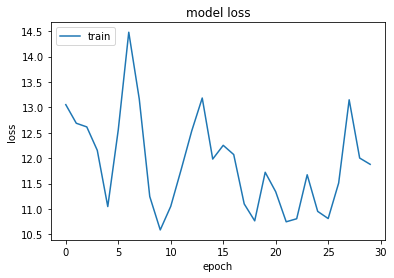

In [29]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [27]:
model.evaluate(eval_dataset)

   3667/Unknown - 28s 8ms/step - loss: 6.2839

6.283917356454159

## Submissions

Submissions are evaluated on the Log of the Mean Absolute Error, calculated for each scalar coupling type, and then averaged across types, so that a 1% decrease in MAE for one type provides the same improvement in score as a 1% decrease for another type.

score=1T∑t=1Tlog(1nt∑i=1nt|yi−yi^|)
Where:

T is the number of scalar coupling types
nt is the number of observations of type t
yi is the actual scalar coupling constant for the observation
yi^ is the predicted scalar coupling constant for the observation
For this metric, the MAE for any group has a floor of 1e-9, so that the minimum (best) possible score for perfect predictions is approximately -20.7232.

## Annex

#### Features description

* dipole_moments.csv - contains the molecular electric dipole moments. These are three dimensional vectors that indicate the charge distribution in the molecule. The first column (molecule_name) are the names of the molecule, the second to fourth column are the X, Y and Z components respectively of the dipole moment.
* magnetic_shielding_tensors.csv - contains the magnetic shielding tensors for all atoms in the molecules. The first column (molecule_name) contains the molecule name, the second column (atom_index) contains the index of the atom in the molecule, the  third to eleventh columns contain the XX, YX, ZX, XY, YY, ZY, XZ, YZ and ZZ elements of the tensor/matrix respectively.
* mulliken_charges.csv - contains the mulliken charges for all atoms in the molecules. The first column (molecule_name) contains the name of the molecule, the second column (atom_index) contains the index of the atom in the molecule, the third column (mulliken_charge) contains the mulliken charge of the atom.
* potential_energy.csv - contains the potential energy of the molecules. The first column (molecule_name) contains the name of the molecule, the second column (potential_energy) contains the potential energy of the molecule.
* scalar_coupling_contributions.csv - The scalar coupling constants in train.csv (or corresponding files) are a sum of four terms. scalar_coupling_contributions.csv contain all these terms. The first column (molecule_name) are the name of the molecule, the second (atom_index_0) and third column (atom_index_1) are the atom indices of the atom-pair, the fourth column indicates the type of coupling, the fifth column (fc) is the Fermi Contact contribution, the sixth column (sd) is the Spin-dipolar contribution, the seventh column (pso) is the Paramagnetic spin-orbit contribution and the eighth column (dso) is the Diamagnetic spin-orbit contribution.

### Test set to validate the code

In [6]:
ut_coupling = pd.DataFrame({
    'molecule_name': ['mol_a', 'mol_b', 'mol_a', 'mol_b', 'mol_b', 'mol_c'],
    'atom_index_0':[ 0, 0, 1, 1, 1, 0],
    'atom_index_1': [ 1, 1, 2, 2, 3, 1],
    'scalar_coupling_constant': [5, 7, 6, 8, 9, 10],
    'coupling_type_1JHC':[ 1, 0, 0, 0, 0, 0], 
    'coupling_type_1JHN':[ 0, 1, 0, 0, 0, 0], 
    'coupling_type_2JHC':[ 0, 0, 1, 0, 0, 0], 
    'coupling_type_2JHH':[ 0, 0, 0, 1, 0, 0], 
    'coupling_type_2JHN':[ 0, 0, 0, 0, 1, 0], 
    'coupling_type_3JHC':[ 0, 0, 0, 0, 0, 1],
    'coupling_type_3JHH':[ 0, 0, 0, 0, 0, 0], 
    'coupling_type_3JHN':[ 0, 0, 0, 0, 0, 0]
})

ut_coupling.head(6)

,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,coupling_type_1JHC,coupling_type_1JHN,coupling_type_2JHC,coupling_type_2JHH,coupling_type_2JHN,coupling_type_3JHC,coupling_type_3JHH,coupling_type_3JHN
0,mol_a,0,1,5,1,0,0,0,0,0,0,0
1,mol_b,0,1,7,0,1,0,0,0,0,0,0
2,mol_a,1,2,6,0,0,1,0,0,0,0,0
3,mol_b,1,2,8,0,0,0,1,0,0,0,0
4,mol_b,1,3,9,0,0,0,0,1,0,0,0
5,mol_c,0,1,10,0,0,0,0,0,1,0,0


In [7]:
ut_molecules = pd.DataFrame({
    'molecule_name': ['mol_a', 'mol_a', 'mol_a', 'mol_b', 'mol_b', 'mol_b', 'mol_b', 'mol_b', 'mol_c', 'mol_c'],
    'atom_index':[ 0, 1, 2, 0, 1, 2, 3, 4, 0, 1],
    'x': [ -0.5, 0.5, 1, -2, -1, 0, 1, 2, 0.5, 1.5  ],
    'y': [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0  ],
    'z': [ -0.5, 0.5, 1, -2, -1, 0, 1, 2, 0.5, 1.5  ],
    'atom_C': [1,0,0,0,0,1,0,0,0,0],
    'atom_F': [0,1,0,0,0,0,1,0,0,0],
    'atom_H': [0,0,1,0,0,0,0,1,0,0], 
    'atom_N': [0,0,0,1,0,0,0,0,1,0],
    'atom_O': [0,0,0,0,1,0,0,0,0,1]
})

ut_molecules.head(10)

,molecule_name,atom_index,x,y,z,atom_C,atom_F,atom_H,atom_N,atom_O
0,mol_a,0,-0.5,0,-0.5,1,0,0,0,0
1,mol_a,1,0.5,0,0.5,0,1,0,0,0
2,mol_a,2,1.0,0,1.0,0,0,1,0,0
3,mol_b,0,-2.0,0,-2.0,0,0,0,1,0
4,mol_b,1,-1.0,0,-1.0,0,0,0,0,1
5,mol_b,2,0.0,0,0.0,1,0,0,0,0
6,mol_b,3,1.0,0,1.0,0,1,0,0,0
7,mol_b,4,2.0,0,2.0,0,0,1,0,0
8,mol_c,0,0.5,0,0.5,0,0,0,1,0
9,mol_c,1,1.5,0,1.5,0,0,0,0,1
